# Importing Libraries and SparkContext

In [159]:
import findspark
findspark.init()

In [160]:
from pyspark.sql import SparkSession
from pyspark.conf import SparkConf
from pyspark.sql.types import * 
import pyspark.sql.functions as F
from pyspark.sql.functions import col, asc,desc
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from pyspark.sql import SQLContext
from pyspark.mllib.stat import Statistics
import pandas as pd
from pyspark.sql.functions import udf
from pyspark.ml.feature import OneHotEncoder, StringIndexer, VectorAssembler,StandardScaler
from pyspark.ml import Pipeline
from sklearn.metrics import confusion_matrix,roc_curve, auc
from pyspark.mllib.evaluation import BinaryClassificationMetrics

spark=SparkSession.builder \
.master ("local[*]")\
.appName("part3")\
.getOrCreate()

In [166]:
sc=spark.sparkContext
sqlContext=SQLContext(sc)

In [167]:
import os
os.getcwd()

'C:\\Users\\pramodh\\Documents\\Coursework\\Fall2022\\BAN5753\\Mini Project'

In [168]:
from platform import python_version

print(python_version())

3.9.6


In [169]:
sc.version #spark version

'3.3.0'

## Read File

In [7]:
df=spark.read \
 .option("header","True")\
 .option("inferSchema","True")\
 .option("sep",";")\
 .csv("XYZ_Bank_Deposit_Data_Classification.csv")
print("There are",df.count(),"rows",len(df.columns),
      "columns" ,"in the data.") 

There are 41188 rows 21 columns in the data.


## Show Sample Data

In [8]:
df.toPandas().head(5)

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


In [9]:
new_columns=[k.replace('.','_') for k in df.columns]
df=df.toDF(*new_columns)
df.toPandas().head(5)

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp_var_rate,cons_price_idx,cons_conf_idx,euribor3m,nr_employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


## Data Types of Columns

In [10]:
df.printSchema()

root
 |-- age: integer (nullable = true)
 |-- job: string (nullable = true)
 |-- marital: string (nullable = true)
 |-- education: string (nullable = true)
 |-- default: string (nullable = true)
 |-- housing: string (nullable = true)
 |-- loan: string (nullable = true)
 |-- contact: string (nullable = true)
 |-- month: string (nullable = true)
 |-- day_of_week: string (nullable = true)
 |-- duration: integer (nullable = true)
 |-- campaign: integer (nullable = true)
 |-- pdays: integer (nullable = true)
 |-- previous: integer (nullable = true)
 |-- poutcome: string (nullable = true)
 |-- emp_var_rate: double (nullable = true)
 |-- cons_price_idx: double (nullable = true)
 |-- cons_conf_idx: double (nullable = true)
 |-- euribor3m: double (nullable = true)
 |-- nr_employed: double (nullable = true)
 |-- y: string (nullable = true)



## Statistics

In [11]:
numeric_features = [t[0] for t in df.dtypes if t[1] != 'string' and t[0] != 'pdays']

df.select(numeric_features).describe().toPandas().transpose()

,0,1,2,3,4
summary,count,mean,stddev,min,max
age,41188,40.02406040594348,10.421249980934043,17,98
duration,41188,258.2850101971448,259.27924883646455,0,4918
campaign,41188,2.567592502670681,2.770013542902331,1,56
previous,41188,0.17296299893172767,0.49490107983928927,0,7
emp_var_rate,41188,0.08188550063178966,1.57095974051703,-3.4,1.4
cons_price_idx,41188,93.5756643682899,0.5788400489540823,92.201,94.767
cons_conf_idx,41188,-40.502600271918276,4.628197856174573,-50.8,-26.9
euribor3m,41188,3.621290812858533,1.7344474048512595,0.634,5.045
nr_employed,41188,5167.035910943957,72.25152766826338,4963.6,5228.1


In [12]:
categorical_features = [t[0] for t in df.dtypes if t[1] == 'string' and t[0] != 'y']

df.select(categorical_features).describe().toPandas().transpose()

,0,1,2,3,4
summary,count,mean,stddev,min,max
job,41188,None,None,admin.,unknown
marital,41188,None,None,divorced,unknown
education,41188,None,None,basic.4y,unknown
default,41188,None,None,no,yes
housing,41188,None,None,no,yes
loan,41188,None,None,no,yes
contact,41188,None,None,cellular,telephone
month,41188,None,None,apr,sep
day_of_week,41188,None,None,fri,wed


In [13]:
len(df.columns),len(numeric_features),len(categorical_features)

(21, 9, 10)

## Target Variable Distribution

In [14]:
df.groupby("y").count().show()

+---+-----+
|  y|count|
+---+-----+
| no|36548|
|yes| 4640|
+---+-----+



## Distribution of Features

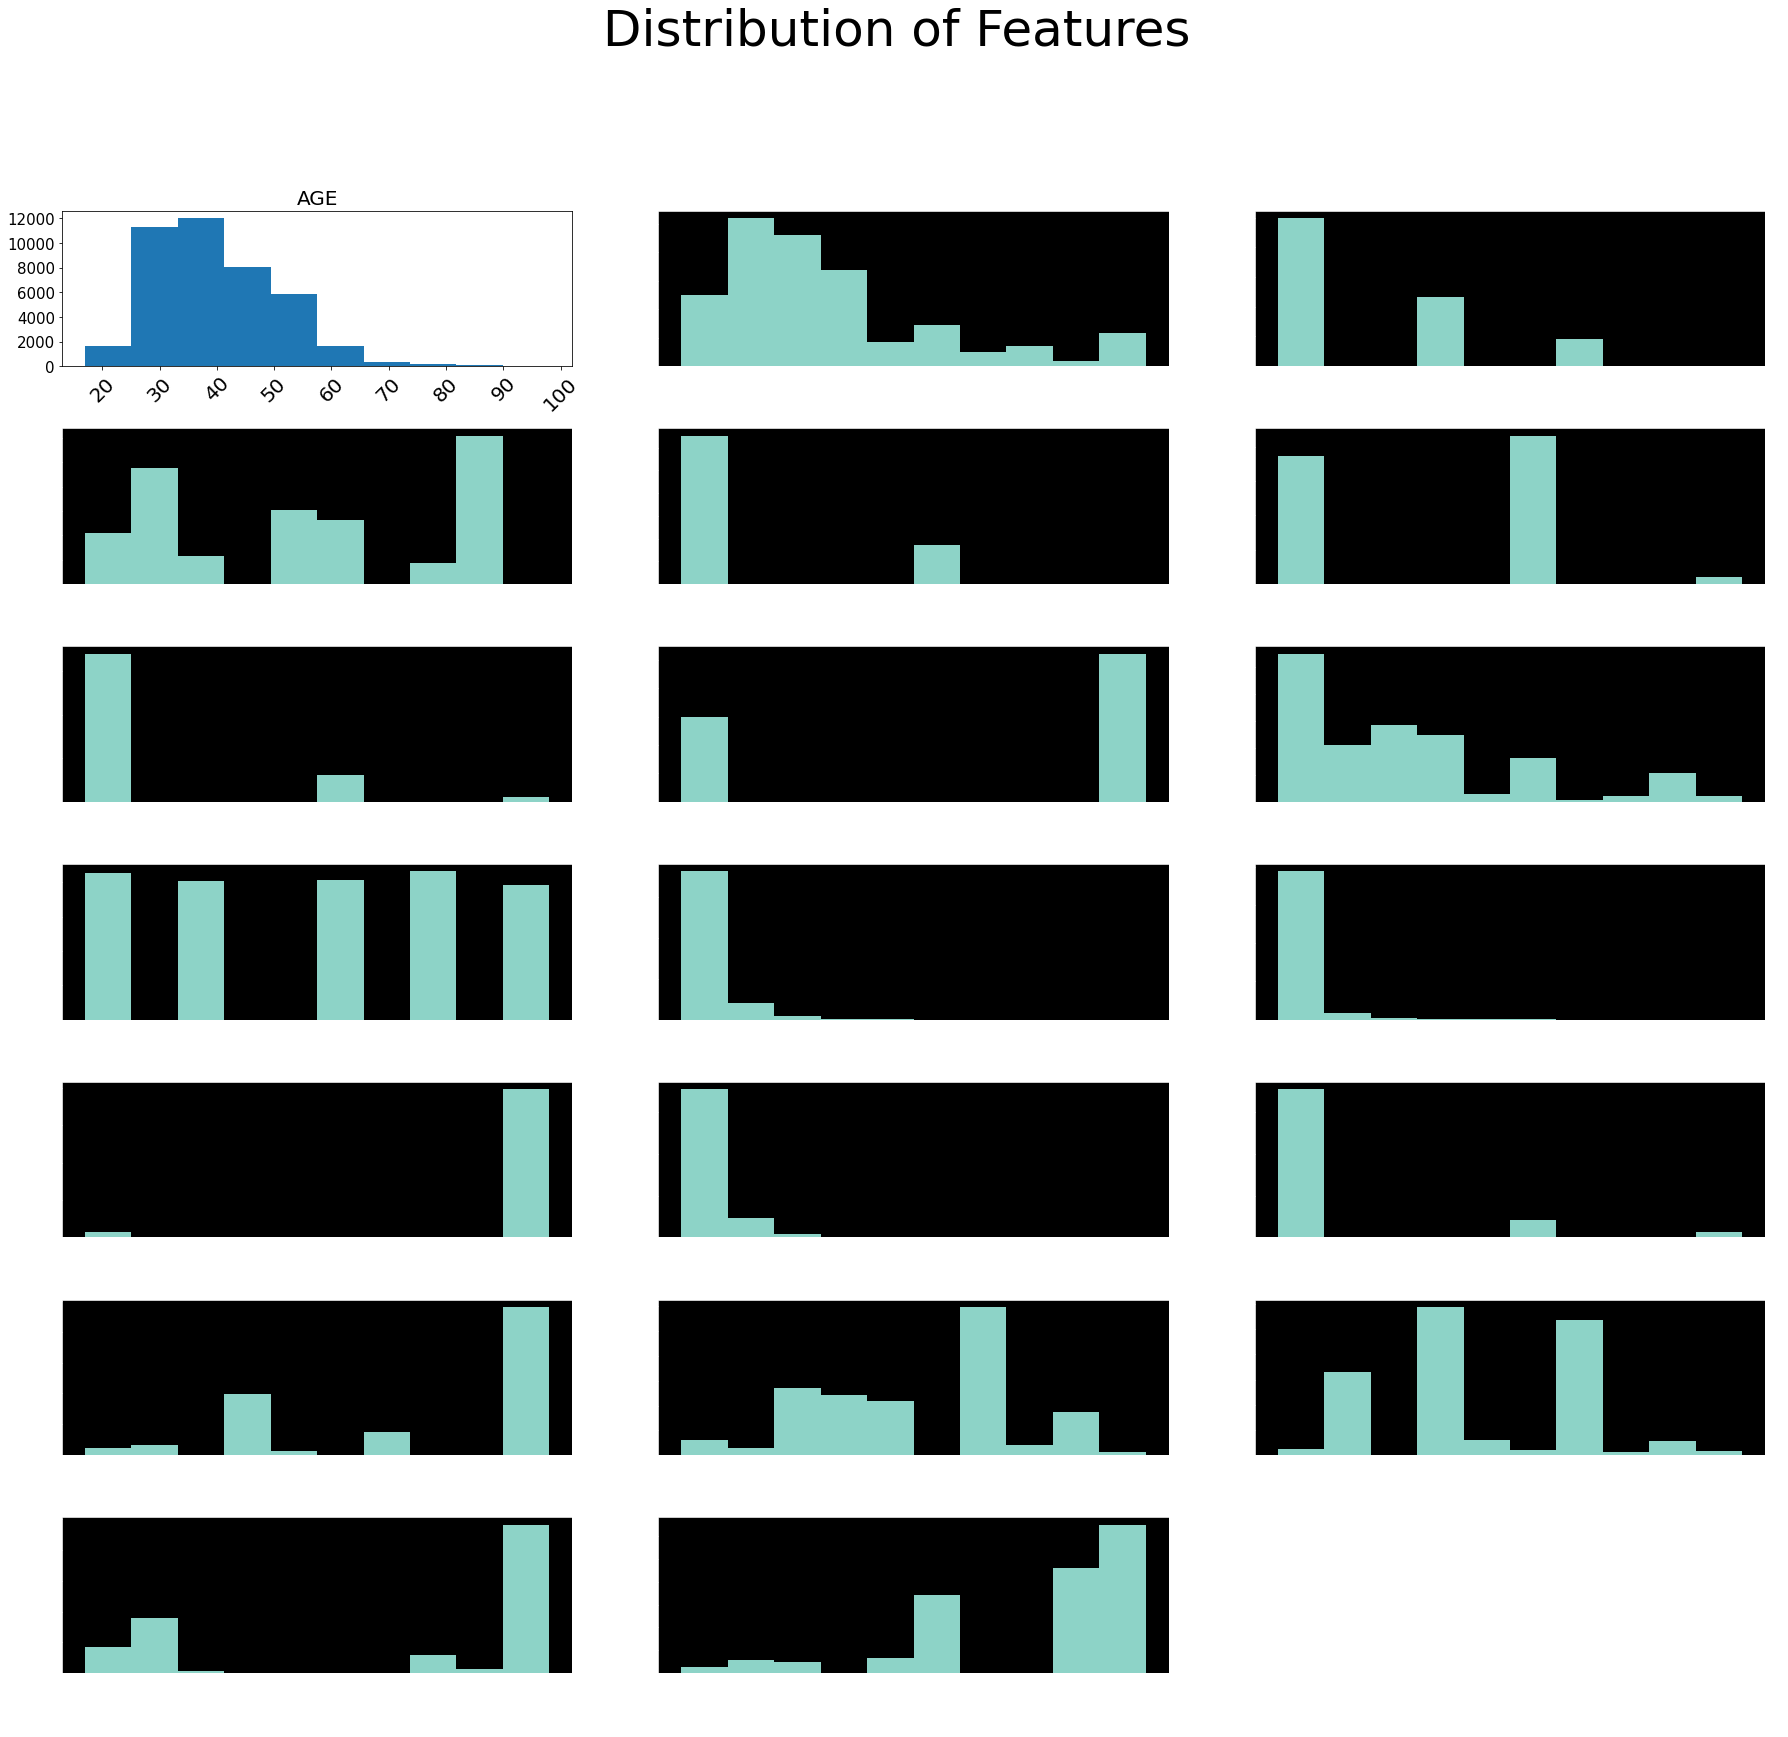

In [15]:
from matplotlib import cm
fig = plt.figure(figsize=(25,25)) ## Plot Size 
st = fig.suptitle("Distribution of Features", fontsize=50,
                  verticalalignment='center') # Plot Main Title 

for col,num in zip(df.toPandas().columns, range(1,21)):
    ax = fig.add_subplot(7,3,num)
    ax.hist(df.toPandas()[col])
    plt.style.use('dark_background') 
    plt.grid(False)
    plt.xticks(rotation=45,fontsize=20)
    plt.yticks(fontsize=15)
    plt.title(col.upper(),fontsize=20)
plt.tight_layout()
st.set_y(0.95)
fig.subplots_adjust(top=0.85,hspace = 0.4)
plt.show()

## Check For Null Values

In [16]:
from pyspark.sql.functions import isnan, when, count, col
df.select([count(when(isnan(c), c)).alias(c) for c in df.columns]).toPandas().head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp_var_rate,cons_price_idx,cons_conf_idx,euribor3m,nr_employed,y
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [17]:
Dict_Null = {col:df.filter(df[col].isNull()).count() for col in df.columns}
Dict_Null

{'age': 0,
 'job': 0,
 'marital': 0,
 'education': 0,
 'default': 0,
 'housing': 0,
 'loan': 0,
 'contact': 0,
 'month': 0,
 'day_of_week': 0,
 'duration': 0,
 'campaign': 0,
 'pdays': 0,
 'previous': 0,
 'poutcome': 0,
 'emp_var_rate': 0,
 'cons_price_idx': 0,
 'cons_conf_idx': 0,
 'euribor3m': 0,
 'nr_employed': 0,
 'y': 0}

In [18]:
from pyspark.sql import functions as F
from pyspark.sql.functions import rank,sum,col
from pyspark.sql import Window

window = Window.rowsBetween(Window.unboundedPreceding,Window.unboundedFollowing)
tab = df.select(['education','age']).\
   groupBy('education').\
       agg(F.count('age').alias('UserCount'),
           F.mean('age').alias('age_AVG'),
           F.min('age').alias('age_MIN'),
           F.max('age').alias('age_MAX')).\
       withColumn('total',sum(col('UserCount')).over(window)).\
       withColumn('Percent',col('UserCount')*100/col('total')).\
       drop(col('total')).sort(desc("Percent"))

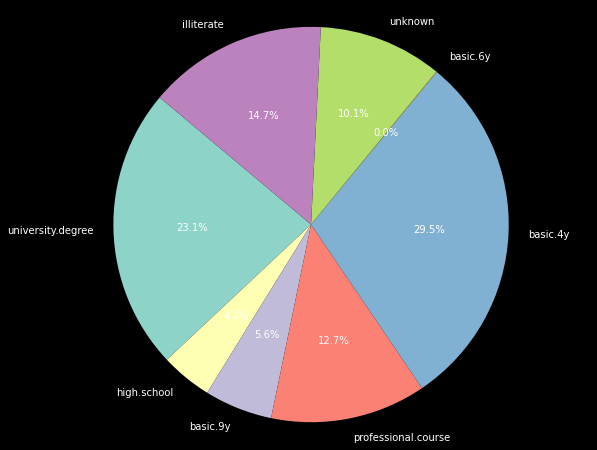

In [19]:
# Data to plot
labels = list(tab.select('education').distinct().toPandas()['education'])
sizes =  list(tab.select('Percent').distinct().toPandas()['Percent'])
# colors = ['gold', 'yellowgreen', 'lightcoral','blue', 'lightskyblue','green','red']
# explode = (0.1, 0.0, 0 ,0.0,0.0,0.0,0.0,0.0 )  # explode 1st slice

# Plot
plt.figure(figsize=(10,8))
plt.pie(sizes,labels=labels, #colors=colors,
        autopct='%1.1f%%', shadow=False, startangle=140)

plt.axis('equal')
plt.show()

# Pearson Correlation

In [20]:
# numeric_features = [t[0] for t in df.dtypes if t[1] != 'string']
numeric_features_df=df.select(numeric_features)
numeric_features_df.toPandas().head()

,age,duration,campaign,previous,emp_var_rate,cons_price_idx,cons_conf_idx,euribor3m,nr_employed
0,56,261,1,0,1.1,93.994,-36.4,4.857,5191.0
1,57,149,1,0,1.1,93.994,-36.4,4.857,5191.0
2,37,226,1,0,1.1,93.994,-36.4,4.857,5191.0
3,40,151,1,0,1.1,93.994,-36.4,4.857,5191.0
4,56,307,1,0,1.1,93.994,-36.4,4.857,5191.0


In [21]:
col_names =numeric_features_df.columns
features = numeric_features_df.rdd.map(lambda row: row[0:])
corr_mat=Statistics.corr(features, method="pearson")
corr_df = pd.DataFrame(corr_mat)
corr_df.index, corr_df.columns = col_names, col_names

corr_df

,age,duration,campaign,previous,emp_var_rate,cons_price_idx,cons_conf_idx,euribor3m,nr_employed
age,1.000000,-0.000866,0.004594,0.024365,-0.000371,0.000857,0.129372,0.010767,-0.017725
duration,-0.000866,1.000000,-0.071699,0.020640,-0.027968,0.005312,-0.008173,-0.032897,-0.044703
campaign,0.004594,-0.071699,1.000000,-0.079141,0.150754,0.127836,-0.013733,0.135133,0.144095
previous,0.024365,0.020640,-0.079141,1.000000,-0.420489,-0.203130,-0.050936,-0.454494,-0.501333
emp_var_rate,-0.000371,-0.027968,0.150754,-0.420489,1.000000,0.775334,0.196041,0.972245,0.906970
cons_price_idx,0.000857,0.005312,0.127836,-0.203130,0.775334,1.000000,0.058986,0.688230,0.522034
cons_conf_idx,0.129372,-0.008173,-0.013733,-0.050936,0.196041,0.058986,1.000000,0.277686,0.100513
euribor3m,0.010767,-0.032897,0.135133,-0.454494,0.972245,0.688230,0.277686,1.000000,0.945154
nr_employed,-0.017725,-0.044703,0.144095,-0.501333,0.906970,0.522034,0.100513,0.945154,1.000000


# Prepare Data for Machine Learning

## a) StringIndexer : Made a list of indexers for all categorical columns

In [22]:
indexers = [StringIndexer(inputCol=column, outputCol=column+"Index").fit(df) for column in categorical_features ]
pipeline_stringindex=Pipeline(stages=indexers)
df_stringindxes=pipeline_stringindex.fit(df).transform(df)
df_stringindxes.toPandas().head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,jobIndex,maritalIndex,educationIndex,defaultIndex,housingIndex,loanIndex,contactIndex,monthIndex,day_of_weekIndex,poutcomeIndex
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,8.0,0.0,4.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,3.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,3.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,0.0,0.0,5.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,3.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0


## b) OneHotEncoderEstimator : Made a list of enocoders based on above indexers and tested pipeline with indexers+encoders

In [23]:
encoders = [OneHotEncoder(inputCol=column+"Index", outputCol=column+"_encoded").fit(df_stringindxes) for column in categorical_features]

pipeline = Pipeline(stages=encoders)
df_encoded = pipeline.fit(df_stringindxes).transform(df_stringindxes)

df_encoded.toPandas().head()

df_encoded.columns

['age',
 'job',
 'marital',
 'education',
 'default',
 'housing',
 'loan',
 'contact',
 'month',
 'day_of_week',
 'duration',
 'campaign',
 'pdays',
 'previous',
 'poutcome',
 'emp_var_rate',
 'cons_price_idx',
 'cons_conf_idx',
 'euribor3m',
 'nr_employed',
 'y',
 'jobIndex',
 'maritalIndex',
 'educationIndex',
 'defaultIndex',
 'housingIndex',
 'loanIndex',
 'contactIndex',
 'monthIndex',
 'day_of_weekIndex',
 'poutcomeIndex',
 'job_encoded',
 'marital_encoded',
 'education_encoded',
 'default_encoded',
 'housing_encoded',
 'loan_encoded',
 'contact_encoded',
 'month_encoded',
 'day_of_week_encoded',
 'poutcome_encoded']

## c) VectorAssembler : Based on enecoders above and tested on df_encoded created above

In [24]:
import pandas as pd
pd.set_option('display.max_colwidth', 80)
pd.set_option("display.max_columns", 12)


assembler = VectorAssembler()\
         .setInputCols (numeric_features+[k+"_encoded" for k in categorical_features])\
         .setOutputCol ("vectorized_features")
        
# In case of missing you can skip the invalid ones
assembler_df=assembler.setHandleInvalid("skip").transform(df_encoded)
assembler_df.toPandas().head()

,age,job,marital,education,default,housing,...,loan_encoded,contact_encoded,month_encoded,day_of_week_encoded,poutcome_encoded,vectorized_features
0,56,housemaid,married,basic.4y,no,no,...,"(1.0, 0.0)",(0.0),"(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0)","(0.0, 1.0, 0.0, 0.0)","(1.0, 0.0)","(56.0, 261.0, 1.0, 0.0, 1.1, 93.994, -36.4, 4.857, 5191.0, 0.0, 0.0, 0.0, 0...."
1,57,services,married,high.school,unknown,no,...,"(1.0, 0.0)",(0.0),"(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0)","(0.0, 1.0, 0.0, 0.0)","(1.0, 0.0)","(57.0, 149.0, 1.0, 0.0, 1.1, 93.994, -36.4, 4.857, 5191.0, 0.0, 0.0, 0.0, 1...."
2,37,services,married,high.school,no,yes,...,"(1.0, 0.0)",(0.0),"(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0)","(0.0, 1.0, 0.0, 0.0)","(1.0, 0.0)","(37.0, 226.0, 1.0, 0.0, 1.1, 93.994, -36.4, 4.857, 5191.0, 0.0, 0.0, 0.0, 1...."
3,40,admin.,married,basic.6y,no,no,...,"(1.0, 0.0)",(0.0),"(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0)","(0.0, 1.0, 0.0, 0.0)","(1.0, 0.0)","(40.0, 151.0, 1.0, 0.0, 1.1, 93.994, -36.4, 4.857, 5191.0, 1.0, 0.0, 0.0, 0...."
4,56,services,married,high.school,no,no,...,"(0.0, 1.0)",(0.0),"(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0)","(0.0, 1.0, 0.0, 0.0)","(1.0, 0.0)","(56.0, 307.0, 1.0, 0.0, 1.1, 93.994, -36.4, 4.857, 5191.0, 0.0, 0.0, 0.0, 1...."


## d) LabelIndexer for output 'y'

In [25]:
label_indexer = StringIndexer()\
         .setInputCol ("y")\
         .setOutputCol ("label")

label_indexer_model=label_indexer.fit(assembler_df)
label_indexer_df=label_indexer_model.transform(assembler_df)

label_indexer_df.select("y","label").toPandas().head()

,y,label
0,no,0.0
1,no,0.0
2,no,0.0
3,no,0.0
4,no,0.0


## e) StandardScaler : based on vectorized_features

In [26]:
scaler = StandardScaler()\
         .setInputCol ("vectorized_features")\
         .setOutputCol ("features")
        
scaler_model=scaler.fit(label_indexer_df)
scaler_df=scaler_model.transform(label_indexer_df)
pd.set_option('display.max_colwidth', 40)
scaler_df.select("vectorized_features","features").toPandas().head(5)

scaler_df.toPandas().head()

,age,job,marital,education,default,housing,...,month_encoded,day_of_week_encoded,poutcome_encoded,vectorized_features,label,features
0,56,housemaid,married,basic.4y,no,no,...,"(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 1.0, 0.0, 0.0)","(1.0, 0.0)","(56.0, 261.0, 1.0, 0.0, 1.1, 93.994,...",0.0,"(5.373635610167063, 1.00663667135437..."
1,57,services,married,high.school,unknown,no,...,"(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 1.0, 0.0, 0.0)","(1.0, 0.0)","(57.0, 149.0, 1.0, 0.0, 1.1, 93.994,...",0.0,"(5.469593388920046, 0.57466997713333..."
2,37,services,married,high.school,no,yes,...,"(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 1.0, 0.0, 0.0)","(1.0, 0.0)","(37.0, 226.0, 1.0, 0.0, 1.1, 93.994,...",0.0,"(3.550437813860381, 0.87164707941029..."
3,40,admin.,married,basic.6y,no,no,...,"(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 1.0, 0.0, 0.0)","(1.0, 0.0)","(40.0, 151.0, 1.0, 0.0, 1.1, 93.994,...",0.0,"(3.8383111501193308, 0.5823836681015..."
4,56,services,married,high.school,no,no,...,"(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 1.0, 0.0, 0.0)","(1.0, 0.0)","(56.0, 307.0, 1.0, 0.0, 1.1, 93.994,...",0.0,"(5.373635610167063, 1.18405156362372..."


# K-Means clustering

In [27]:
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator
silhouette_score=[]
evaluator = ClusteringEvaluator(predictionCol='prediction', featuresCol='features', \
                                metricName='silhouette', distanceMeasure='squaredEuclidean')
for i in range(2,10):
    
    KMeans_algo=KMeans(featuresCol='features', k=i).setSeed(1)
    
    KMeans_fit=KMeans_algo.fit(scaler_df)
    
    output=KMeans_fit.transform(scaler_df)
    
    
    
    score=evaluator.evaluate(output)
    
    silhouette_score.append(score)
    
    print("Silhouette Score:",score)

Silhouette Score: 0.20892598034686086
Silhouette Score: 0.0990804184151814
Silhouette Score: 0.11233283323361054
Silhouette Score: 0.11004122630508252
Silhouette Score: 0.10802982647873823
Silhouette Score: 0.11958416436737011
Silhouette Score: 0.10656492066975279
Silhouette Score: 0.10814132133419137


Text(0, 0.5, 'cost')

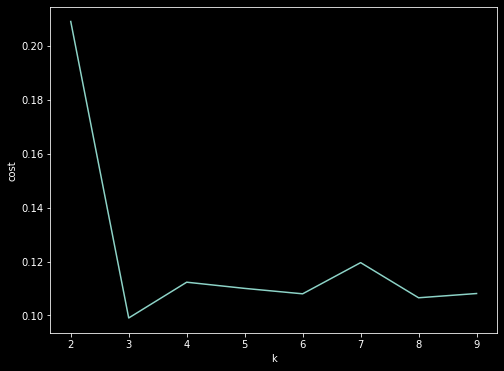

In [28]:
#Visualizing the silhouette scores in a plot
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1,1, figsize =(8,6))
ax.plot(range(2,10),silhouette_score)
ax.set_xlabel('k')
ax.set_ylabel('cost')

In [29]:
KMeans_algo=KMeans(featuresCol='features', k=7).setSeed(1)

KMeans_fit=KMeans_algo.fit(scaler_df)

output=KMeans_fit.transform(scaler_df)

In [30]:
df_withClusters=output.select(numeric_features+categorical_features+['y','prediction'])

In [31]:
df_withClusters=df_withClusters.withColumnRenamed("prediction","cluster")

In [32]:
df_withClusters = df_withClusters.withColumn("cluster", 
                                  df_withClusters["cluster"]
                                  .cast('string'))

In [33]:
df_withClusters.toPandas().head()

,age,duration,campaign,previous,emp_var_rate,cons_price_idx,...,contact,month,day_of_week,poutcome,y,cluster
0,56,261,1,0,1.1,93.994,...,telephone,may,mon,nonexistent,no,1
1,57,149,1,0,1.1,93.994,...,telephone,may,mon,nonexistent,no,1
2,37,226,1,0,1.1,93.994,...,telephone,may,mon,nonexistent,no,1
3,40,151,1,0,1.1,93.994,...,telephone,may,mon,nonexistent,no,6
4,56,307,1,0,1.1,93.994,...,telephone,may,mon,nonexistent,no,1


In [34]:
categorical_features.append('cluster')

## a) StringIndexer : Made a list of indexers for all categorical columns

In [174]:
indexers = [StringIndexer(inputCol=column, outputCol=column+"Index").fit(df_withClusters) for column in categorical_features ]
pipeline_stringindex=Pipeline(stages=indexers)
df_stringindxes=pipeline_stringindex.fit(df_withClusters).transform(df_withClusters)
df_stringindxes.toPandas().head()

,age,duration,campaign,previous,emp_var_rate,cons_price_idx,...,loanIndex,contactIndex,monthIndex,day_of_weekIndex,poutcomeIndex,clusterIndex
0,56,261,1,0,1.1,93.994,...,0.0,1.0,0.0,1.0,0.0,1.0
1,57,149,1,0,1.1,93.994,...,0.0,1.0,0.0,1.0,0.0,1.0
2,37,226,1,0,1.1,93.994,...,0.0,1.0,0.0,1.0,0.0,1.0
3,40,151,1,0,1.1,93.994,...,0.0,1.0,0.0,1.0,0.0,6.0
4,56,307,1,0,1.1,93.994,...,1.0,1.0,0.0,1.0,0.0,1.0


## b) OneHotEncoderEstimator : Made a list of enocoders based on above indexers and tested pipeline with indexers+encoders

In [175]:
encoders = [OneHotEncoder(inputCol=column+"Index", outputCol=column+"_encoded").fit(df_stringindxes) for column in categorical_features]

pipeline = Pipeline(stages=encoders)
df_encoded = pipeline.fit(df_stringindxes).transform(df_stringindxes)

df_encoded.toPandas().head()

df_encoded.columns

['age',
 'duration',
 'campaign',
 'previous',
 'emp_var_rate',
 'cons_price_idx',
 'cons_conf_idx',
 'euribor3m',
 'nr_employed',
 'job',
 'marital',
 'education',
 'default',
 'housing',
 'loan',
 'contact',
 'month',
 'day_of_week',
 'poutcome',
 'y',
 'cluster',
 'jobIndex',
 'maritalIndex',
 'educationIndex',
 'defaultIndex',
 'housingIndex',
 'loanIndex',
 'contactIndex',
 'monthIndex',
 'day_of_weekIndex',
 'poutcomeIndex',
 'clusterIndex',
 'job_encoded',
 'marital_encoded',
 'education_encoded',
 'default_encoded',
 'housing_encoded',
 'loan_encoded',
 'contact_encoded',
 'month_encoded',
 'day_of_week_encoded',
 'poutcome_encoded',
 'cluster_encoded']

## c) VectorAssembler : Based on enecoders above and tested on df_encoded created above

In [176]:
import pandas as pd
pd.set_option('display.max_colwidth', 80)
pd.set_option("display.max_columns", 12)


assembler = VectorAssembler()\
         .setInputCols (numeric_features+[k+"_encoded" for k in categorical_features])\
         .setOutputCol ("vectorized_features")
        
# In case of missing you can skip the invalid ones
assembler_df=assembler.setHandleInvalid("skip").transform(df_encoded)
assembler_df.toPandas().head()

,age,duration,campaign,previous,emp_var_rate,cons_price_idx,...,contact_encoded,month_encoded,day_of_week_encoded,poutcome_encoded,cluster_encoded,vectorized_features
0,56,261,1,0,1.1,93.994,...,(0.0),"(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0)","(0.0, 1.0, 0.0, 0.0)","(1.0, 0.0)","(0.0, 1.0, 0.0, 0.0, 0.0, 0.0)","(56.0, 261.0, 1.0, 0.0, 1.1, 93.994, -36.4, 4.857, 5191.0, 0.0, 0.0, 0.0, 0...."
1,57,149,1,0,1.1,93.994,...,(0.0),"(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0)","(0.0, 1.0, 0.0, 0.0)","(1.0, 0.0)","(0.0, 1.0, 0.0, 0.0, 0.0, 0.0)","(57.0, 149.0, 1.0, 0.0, 1.1, 93.994, -36.4, 4.857, 5191.0, 0.0, 0.0, 0.0, 1...."
2,37,226,1,0,1.1,93.994,...,(0.0),"(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0)","(0.0, 1.0, 0.0, 0.0)","(1.0, 0.0)","(0.0, 1.0, 0.0, 0.0, 0.0, 0.0)","(37.0, 226.0, 1.0, 0.0, 1.1, 93.994, -36.4, 4.857, 5191.0, 0.0, 0.0, 0.0, 1...."
3,40,151,1,0,1.1,93.994,...,(0.0),"(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0)","(0.0, 1.0, 0.0, 0.0)","(1.0, 0.0)","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0)","(40.0, 151.0, 1.0, 0.0, 1.1, 93.994, -36.4, 4.857, 5191.0, 1.0, 0.0, 0.0, 0...."
4,56,307,1,0,1.1,93.994,...,(0.0),"(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0)","(0.0, 1.0, 0.0, 0.0)","(1.0, 0.0)","(0.0, 1.0, 0.0, 0.0, 0.0, 0.0)","(56.0, 307.0, 1.0, 0.0, 1.1, 93.994, -36.4, 4.857, 5191.0, 0.0, 0.0, 0.0, 1...."


## d) LabelIndexer for output 'y'

In [177]:
label_indexer = StringIndexer()\
         .setInputCol ("y")\
         .setOutputCol ("label")

label_indexer_model=label_indexer.fit(assembler_df)
label_indexer_df=label_indexer_model.transform(assembler_df)

label_indexer_df.select("y","label").toPandas().head()

,y,label
0,no,0.0
1,no,0.0
2,no,0.0
3,no,0.0
4,no,0.0


# e) StandardScaler : based on vectorized_features and tested it

In [178]:
scaler = StandardScaler()\
         .setInputCol ("vectorized_features")\
         .setOutputCol ("features")
        
scaler_model=scaler.fit(label_indexer_df)
scaler_df=scaler_model.transform(label_indexer_df)
pd.set_option('display.max_colwidth', 40)
scaler_df.select("vectorized_features","features").toPandas().head(5)

scaler_df.toPandas().head()

,age,duration,campaign,previous,emp_var_rate,cons_price_idx,...,day_of_week_encoded,poutcome_encoded,cluster_encoded,vectorized_features,label,features
0,56,261,1,0,1.1,93.994,...,"(0.0, 1.0, 0.0, 0.0)","(1.0, 0.0)","(0.0, 1.0, 0.0, 0.0, 0.0, 0.0)","(56.0, 261.0, 1.0, 0.0, 1.1, 93.994,...",0.0,"(5.373635610167063, 1.00663667135437..."
1,57,149,1,0,1.1,93.994,...,"(0.0, 1.0, 0.0, 0.0)","(1.0, 0.0)","(0.0, 1.0, 0.0, 0.0, 0.0, 0.0)","(57.0, 149.0, 1.0, 0.0, 1.1, 93.994,...",0.0,"(5.469593388920046, 0.57466997713333..."
2,37,226,1,0,1.1,93.994,...,"(0.0, 1.0, 0.0, 0.0)","(1.0, 0.0)","(0.0, 1.0, 0.0, 0.0, 0.0, 0.0)","(37.0, 226.0, 1.0, 0.0, 1.1, 93.994,...",0.0,"(3.550437813860381, 0.87164707941029..."
3,40,151,1,0,1.1,93.994,...,"(0.0, 1.0, 0.0, 0.0)","(1.0, 0.0)","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0)","(40.0, 151.0, 1.0, 0.0, 1.1, 93.994,...",0.0,"(3.8383111501193308, 0.5823836681015..."
4,56,307,1,0,1.1,93.994,...,"(0.0, 1.0, 0.0, 0.0)","(1.0, 0.0)","(0.0, 1.0, 0.0, 0.0, 0.0, 0.0)","(56.0, 307.0, 1.0, 0.0, 1.1, 93.994,...",0.0,"(5.373635610167063, 1.18405156362372..."


# Train / Test Split on pipeline_df above

In [42]:
train_wo_smote, test_wo_smote = scaler_df.randomSplit([0.8, 0.2], seed = 1)
print("Training Dataset Count: " + str(train_wo_smote.count()))
print("Test Dataset Count: " + str(test_wo_smote.count()))

train_wo_smote.groupby("label").count().show()

Training Dataset Count: 33026
Test Dataset Count: 8162
+-----+-----+
|label|count|
+-----+-----+
|  0.0|29340|
|  1.0| 3686|
+-----+-----+



In [43]:
test_wo_smote.groupby("label").count().show()

+-----+-----+
|label|count|
+-----+-----+
|  0.0| 7208|
|  1.0|  954|
+-----+-----+



In [44]:
models_list=[]
accuracies_list=[]
aucs_list=[]
model_objects_list=[]

# Model Training

## Model 1 : Logistic Regression

In [45]:
from pyspark.ml.classification import LogisticRegression
lr = LogisticRegression(featuresCol = 'features', labelCol = 'label', maxIter=5)
lrModel = lr.fit(train_wo_smote)
predictions = lrModel.transform(test_wo_smote)
#predictions_train = lrModel.transform(train)
predictions.select('label', 'features',  'rawPrediction', 'prediction', 'probability').toPandas().head(5)

,label,features,rawPrediction,prediction,probability
0,0.0,"(1.823197796306682, 0.33554555711812...","[4.297171008146881, -4.297171008146881]",0.0,"[0.9865756661904715, 0.0134243338095..."
1,1.0,"(1.823197796306682, 0.82150808811678...","[1.5863370424381578, -1.586337042438...",0.0,"[0.8301001263177685, 0.1698998736822..."
2,1.0,"(1.823197796306682, 1.15319679975079...","[1.1862449183961203, -1.186244918396...",0.0,"[0.7660687982954982, 0.2339312017045..."
3,1.0,"(1.823197796306682, 1.68929832204296...","[0.45850733281436484, -0.45850733281...",0.0,"[0.6126600143140338, 0.3873399856859..."
4,0.0,"(1.823197796306682, 4.47779760705909...","[-2.483174743086094, 2.483174743086094]",1.0,"[0.07704614269006933, 0.922953857309..."


### Confusion Matrix

Confusion matrix, without normalization
[[ 398  556]
 [ 177 7031]]


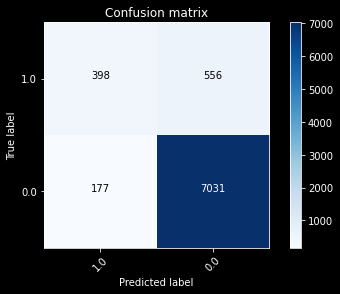

In [46]:
class_names=[1.0,0.0]
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

y_true = predictions.select("label")
y_true = y_true.toPandas()

y_pred = predictions.select("prediction")
y_pred = y_pred.toPandas()

cnf_matrix = confusion_matrix(y_true, y_pred,labels=class_names)
#cnf_matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix')
plt.show()

### Accuracy

In [47]:
accuracy = predictions.filter(predictions.label == predictions.prediction).count() / float(predictions.count())
print("Accuracy : ",accuracy)

Accuracy :  0.9101935800049008


## ROC Curve

C:\Apps\opt\spark-3.3.0-bin-hadoop3\python\pyspark\sql\context.py:157: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


Logistic Regression Area Under ROC
Area under ROC = 0.935


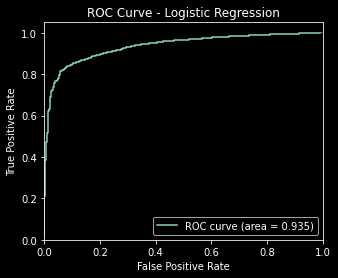

In [48]:

#ROC Grafik
PredAndLabels           = predictions.select("probability", "label")
PredAndLabels_collect   = PredAndLabels.collect()
PredAndLabels_list      = [(float(i[0][0]), 1.0-float(i[1])) for i in PredAndLabels_collect]
PredAndLabels           = sc.parallelize(PredAndLabels_list)

metrics = BinaryClassificationMetrics(PredAndLabels)

# Area under ROC
print("Logistic Regression Area Under ROC")
print("Area under ROC = %.3f" % metrics.areaUnderROC)

# Visualization
FPR = dict()                                                        # FPR: False Positive Rate
tpr = dict()                                                        # TPR: True Positive Rate
roc_auc = dict()
 
y_test = [i[1] for i in PredAndLabels_list]
y_score = [i[0] for i in PredAndLabels_list]
 
fpr, tpr, _ = roc_curve(y_test, y_score)
roc_auc = auc(fpr, tpr)
 
plt.figure(figsize=(5,4))
plt.plot(fpr, tpr, label='ROC curve (area = %0.3f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Logistic Regression')
plt.legend(loc="lower right")
plt.show()



In [49]:
models_list.append('LogisticRegression')
accuracies_list.append(accuracy)
aucs_list.append(metrics.areaUnderROC)
model_objects_list.append(lrModel)

## Model 2 : DecisionTreeClassifier

In [50]:
from pyspark.ml.classification import DecisionTreeClassifier

dt = DecisionTreeClassifier(featuresCol = 'features', labelCol = 'label', maxDepth = 3)
dtModel = dt.fit(train_wo_smote)
predictions = dtModel.transform(test_wo_smote)
predictions.select('label', 'features',  'rawPrediction', 'prediction', 'probability').toPandas().head(5)

y_true = predictions.select("label")
y_true = y_true.toPandas()

y_pred = predictions.select("prediction")
y_pred = y_pred.toPandas()

### Confusion Matrix

Confusion matrix, without normalization
[[ 418  536]
 [ 219 6989]]


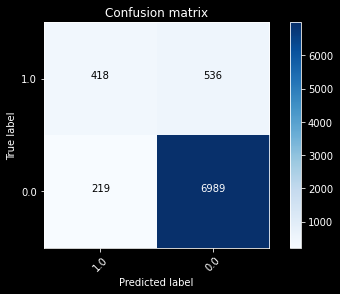

In [51]:
cnf_matrix = confusion_matrix(y_true, y_pred,labels=class_names)
#cnf_matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix')
plt.show()

### Accuracy

In [52]:
accuracy = predictions.filter(predictions.label == predictions.prediction).count() / float(predictions.count())
print("Accuracy : ",accuracy)

Accuracy :  0.9074981622151433


## ROC Curve

C:\Apps\opt\spark-3.3.0-bin-hadoop3\python\pyspark\sql\context.py:157: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


Decision Tree Area Under ROC
Area under ROC = 0.854


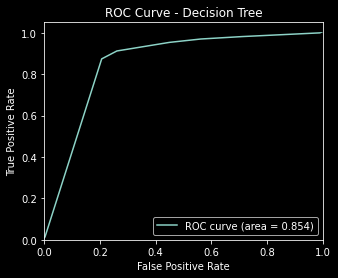

In [53]:
#ROC Grafik
PredAndLabels           = predictions.select("probability", "label")
PredAndLabels_collect   = PredAndLabels.collect()
PredAndLabels_list      = [(float(i[0][0]), 1.0-float(i[1])) for i in PredAndLabels_collect]
PredAndLabels           = sc.parallelize(PredAndLabels_list)

metrics = BinaryClassificationMetrics(PredAndLabels)

# Area under ROC
print("Decision Tree Area Under ROC")
print("Area under ROC = %.3f" % metrics.areaUnderROC)

# Visualization
FPR = dict()                                                        # FPR: False Positive Rate
tpr = dict()                                                        # TPR: True Positive Rate
roc_auc = dict()
 
y_test = [i[1] for i in PredAndLabels_list]
y_score = [i[0] for i in PredAndLabels_list]
 
fpr, tpr, _ = roc_curve(y_test, y_score)
roc_auc = auc(fpr, tpr)
 
plt.figure(figsize=(5,4))
plt.plot(fpr, tpr, label='ROC curve (area = %0.3f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Decision Tree')
plt.legend(loc="lower right")
plt.show()



In [54]:
models_list.append('DecisionTreeClassifier')
accuracies_list.append(accuracy)
aucs_list.append(metrics.areaUnderROC)
model_objects_list.append(dtModel)

##  Model 3: Random Forest Classifier

In [55]:
from pyspark.ml.classification import RandomForestClassifier

rf = RandomForestClassifier(featuresCol = 'features', labelCol = 'label')
rfModel = rf.fit(train_wo_smote)
predictions = rfModel.transform(test_wo_smote)
predictions.select('label', 'features',  'rawPrediction', 'prediction', 'probability').toPandas().head(5)

y_true = predictions.select("label")
y_true = y_true.toPandas()

y_pred = predictions.select("prediction")
y_pred = y_pred.toPandas()

### Confusion Matrix

Confusion matrix, without normalization
[[ 160  794]
 [  47 7161]]


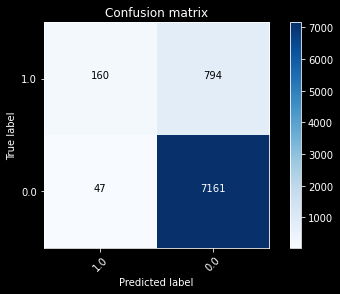

In [56]:
cnf_matrix = confusion_matrix(y_true, y_pred,labels=class_names)
#cnf_matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix')
plt.show()

### Accuracy

In [57]:
accuracy = predictions.filter(predictions.label == predictions.prediction).count() / float(predictions.count())
print("Accuracy : ",accuracy)

Accuracy :  0.8969615290370008


## ROC Curve

C:\Apps\opt\spark-3.3.0-bin-hadoop3\python\pyspark\sql\context.py:157: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


Random Forest Area Under ROC
Area under ROC = 0.925


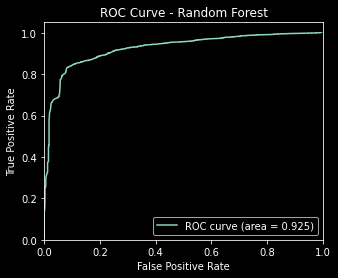

In [58]:
#ROC Grafik
PredAndLabels           = predictions.select("probability", "label")
PredAndLabels_collect   = PredAndLabels.collect()
PredAndLabels_list      = [(float(i[0][0]), 1.0-float(i[1])) for i in PredAndLabels_collect]
PredAndLabels           = sc.parallelize(PredAndLabels_list)

metrics = BinaryClassificationMetrics(PredAndLabels)

# Area under ROC
print("Random Forest Area Under ROC")
print("Area under ROC = %.3f" % metrics.areaUnderROC)

# Visualization
FPR = dict()                                                        # FPR: False Positive Rate
tpr = dict()                                                        # TPR: True Positive Rate
roc_auc = dict()
 
y_test = [i[1] for i in PredAndLabels_list]
y_score = [i[0] for i in PredAndLabels_list]
 
fpr, tpr, _ = roc_curve(y_test, y_score)
roc_auc = auc(fpr, tpr)
 
plt.figure(figsize=(5,4))
plt.plot(fpr, tpr, label='ROC curve (area = %0.3f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Random Forest')
plt.legend(loc="lower right")
plt.show()



In [59]:
models_list.append('RandomForestClassifier')
accuracies_list.append(accuracy)
aucs_list.append(metrics.areaUnderROC)
model_objects_list.append(rfModel)

 ## Model 4: Gradient-boosted Tree Classifier

In [60]:
from pyspark.ml.classification import GBTClassifier

gbt = GBTClassifier(maxIter=10)
gbtModel = gbt.fit(train_wo_smote)
predictions = gbtModel.transform(test_wo_smote)
predictions.select('label', 'features',  'rawPrediction', 'prediction', 'probability').toPandas().head(5)

y_true = predictions.select("label")
y_true = y_true.toPandas()

y_pred = predictions.select("prediction")
y_pred = y_pred.toPandas()

### Confusion Matrix

Confusion matrix, without normalization
[[ 497  457]
 [ 250 6958]]


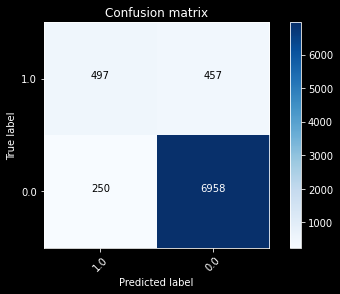

In [61]:
cnf_matrix = confusion_matrix(y_true, y_pred,labels=class_names)
#cnf_matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix')
plt.show()

### Accuracy

In [62]:
accuracy = predictions.filter(predictions.label == predictions.prediction).count() / float(predictions.count())
print("Accuracy : ",accuracy)

Accuracy :  0.9133790737564322


## ROC Curve

C:\Apps\opt\spark-3.3.0-bin-hadoop3\python\pyspark\sql\context.py:157: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


Gradient-boosted Tree Area Under ROC
Area under ROC = 0.944


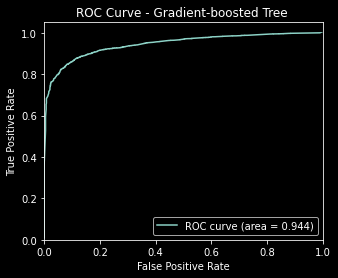

In [63]:
#ROC Grafik
PredAndLabels           = predictions.select("probability", "label")
PredAndLabels_collect   = PredAndLabels.collect()
PredAndLabels_list      = [(float(i[0][0]), 1.0-float(i[1])) for i in PredAndLabels_collect]
PredAndLabels           = sc.parallelize(PredAndLabels_list)

metrics = BinaryClassificationMetrics(PredAndLabels)

# Area under ROC
print("Gradient-boosted Tree Area Under ROC")
print("Area under ROC = %.3f" % metrics.areaUnderROC)

# Visualization
FPR = dict()                                                        # FPR: False Positive Rate
tpr = dict()                                                        # TPR: True Positive Rate
roc_auc = dict()
 
y_test = [i[1] for i in PredAndLabels_list]
y_score = [i[0] for i in PredAndLabels_list]
 
fpr, tpr, _ = roc_curve(y_test, y_score)
roc_auc = auc(fpr, tpr)
 
plt.figure(figsize=(5,4))
plt.plot(fpr, tpr, label='ROC curve (area = %0.3f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Gradient-boosted Tree ')
plt.legend(loc="lower right")
plt.show()

In [64]:
models_list.append('GBTClassifier')
accuracies_list.append(accuracy)
aucs_list.append(metrics.areaUnderROC)
model_objects_list.append(gbtModel)

# Handling Imbalance with SMOTE

### Splitting Train and Test before Resampling

In [65]:
train, test = df_withClusters.randomSplit([0.8, 0.2], seed = 1)
print("Training Dataset Count: " + str(train.count()))
print("Test Dataset Count: " + str(test.count()))

Training Dataset Count: 33026
Test Dataset Count: 8162


In [66]:
train.printSchema()

root
 |-- age: integer (nullable = true)
 |-- duration: integer (nullable = true)
 |-- campaign: integer (nullable = true)
 |-- previous: integer (nullable = true)
 |-- emp_var_rate: double (nullable = true)
 |-- cons_price_idx: double (nullable = true)
 |-- cons_conf_idx: double (nullable = true)
 |-- euribor3m: double (nullable = true)
 |-- nr_employed: double (nullable = true)
 |-- job: string (nullable = true)
 |-- marital: string (nullable = true)
 |-- education: string (nullable = true)
 |-- default: string (nullable = true)
 |-- housing: string (nullable = true)
 |-- loan: string (nullable = true)
 |-- contact: string (nullable = true)
 |-- month: string (nullable = true)
 |-- day_of_week: string (nullable = true)
 |-- poutcome: string (nullable = true)
 |-- y: string (nullable = true)
 |-- cluster: string (nullable = false)



###  Resampling Train Using SMOTENC

In [67]:
# import library
from imblearn.over_sampling import SMOTENC
from collections import Counter

x_train = train.select(numeric_features+categorical_features).toPandas()
categorical_features_indxs=[x_train.columns.get_loc(col) for col in categorical_features]
y_train = train.select('y').toPandas()
smote = SMOTENC(categorical_features=categorical_features_indxs,sampling_strategy=0.25,random_state=2022)

# fit predictor and target variable
x_train_smote, y_train_smote = smote.fit_resample(x_train, y_train)

print('Original dataset shape', y_train.value_counts())
print('Resample dataset shape', y_train_smote.value_counts())

Original dataset shape y  
no     29340
yes     3686
dtype: int64
Resample dataset shape y  
no     29340
yes     7335
dtype: int64


### Combining Train and Test for preprocessing

In [68]:
df_train_smote=pd.concat([x_train_smote, y_train_smote],axis=1)
train_size=df_train_smote.shape[0]
df_smote=pd.concat([df_train_smote,test.toPandas()[numeric_features+categorical_features+['y']]]).reset_index(drop=True)
df_smote_sprk=sqlContext.createDataFrame(df_smote)

# Prepare Data for Machine Learning

## a) StringIndexer : Made a list of indexers for all categorical columns

In [69]:
indexers = [StringIndexer(inputCol=column, outputCol=column+"Index").fit(df_smote_sprk) for column in categorical_features ]
pipeline_stringindex=Pipeline(stages=indexers)
df_stringindxes=pipeline_stringindex.fit(df_smote_sprk).transform(df_smote_sprk)
df_stringindxes.toPandas().head()

,age,duration,campaign,previous,emp_var_rate,cons_price_idx,...,loanIndex,contactIndex,monthIndex,day_of_weekIndex,poutcomeIndex,clusterIndex
0,18,75,1,0,-0.1,93.200,...,0.0,1.0,4.0,0.0,0.0,5.0
1,18,103,1,0,-1.8,92.843,...,1.0,0.0,8.0,3.0,0.0,0.0
2,19,43,3,0,-1.8,93.075,...,0.0,0.0,5.0,3.0,0.0,0.0
3,19,72,4,0,-1.8,93.075,...,1.0,0.0,5.0,4.0,0.0,0.0
4,19,108,5,0,-1.8,93.075,...,0.0,0.0,5.0,4.0,0.0,0.0


## b) OneHotEncoderEstimator : Made a list of enocoders based on above indexers and tested pipeline with indexers+encoders

In [70]:
encoders = [OneHotEncoder(inputCol=column+"Index", outputCol=column+"_encoded").fit(df_stringindxes) for column in categorical_features]

pipeline = Pipeline(stages=encoders)
df_encoded = pipeline.fit(df_stringindxes).transform(df_stringindxes)

df_encoded.toPandas().head()

,age,duration,campaign,previous,emp_var_rate,cons_price_idx,...,loan_encoded,contact_encoded,month_encoded,day_of_week_encoded,poutcome_encoded,cluster_encoded
0,18,75,1,0,-0.1,93.200,...,"(1.0, 0.0)",(0.0),"(0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, ...","(1.0, 0.0, 0.0, 0.0)","(1.0, 0.0)","(0.0, 0.0, 0.0, 0.0, 0.0, 1.0)"
1,18,103,1,0,-1.8,92.843,...,"(0.0, 1.0)",(1.0),"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 1.0)","(1.0, 0.0)","(1.0, 0.0, 0.0, 0.0, 0.0, 0.0)"
2,19,43,3,0,-1.8,93.075,...,"(1.0, 0.0)",(1.0),"(0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, ...","(0.0, 0.0, 0.0, 1.0)","(1.0, 0.0)","(1.0, 0.0, 0.0, 0.0, 0.0, 0.0)"
3,19,72,4,0,-1.8,93.075,...,"(0.0, 1.0)",(1.0),"(0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0)","(1.0, 0.0)","(1.0, 0.0, 0.0, 0.0, 0.0, 0.0)"
4,19,108,5,0,-1.8,93.075,...,"(1.0, 0.0)",(1.0),"(0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0)","(1.0, 0.0)","(1.0, 0.0, 0.0, 0.0, 0.0, 0.0)"


## c) VectorAssembler : Based on enecoders above and tested on df_encoded created above

In [71]:
import pandas as pd
pd.set_option('display.max_colwidth', 80)
pd.set_option("display.max_columns", 12)


In [72]:
assembler = VectorAssembler()\
         .setInputCols (numeric_features+[k+"_encoded" for k in categorical_features])\
         .setOutputCol ("vectorized_features")
        
# In case of missing you can skip the invalid ones
assembler_df=assembler.setHandleInvalid("skip").transform(df_encoded)
assembler_df.toPandas().head()

,age,duration,campaign,previous,emp_var_rate,cons_price_idx,...,contact_encoded,month_encoded,day_of_week_encoded,poutcome_encoded,cluster_encoded,vectorized_features
0,18,75,1,0,-0.1,93.200,...,(0.0),"(0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0)","(1.0, 0.0, 0.0, 0.0)","(1.0, 0.0)","(0.0, 0.0, 0.0, 0.0, 0.0, 1.0)","(18.0, 75.0, 1.0, 0.0, -0.1, 93.2, -42.0, 4.245, 5195.8, 0.0, 0.0, 0.0, 0.0,..."
1,18,103,1,0,-1.8,92.843,...,(1.0),"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0)","(0.0, 0.0, 0.0, 1.0)","(1.0, 0.0)","(1.0, 0.0, 0.0, 0.0, 0.0, 0.0)","(18.0, 103.0, 1.0, 0.0, -1.8, 92.843, -50.0, 1.687, 5099.1, 0.0, 0.0, 0.0, 0..."
2,19,43,3,0,-1.8,93.075,...,(1.0),"(0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0)","(0.0, 0.0, 0.0, 1.0)","(1.0, 0.0)","(1.0, 0.0, 0.0, 0.0, 0.0, 0.0)","(19.0, 43.0, 3.0, 0.0, -1.8, 93.075, -47.1, 1.453, 5099.1, 0.0, 0.0, 0.0, 0...."
3,19,72,4,0,-1.8,93.075,...,(1.0),"(0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0)","(0.0, 0.0, 0.0, 0.0)","(1.0, 0.0)","(1.0, 0.0, 0.0, 0.0, 0.0, 0.0)","(19.0, 72.0, 4.0, 0.0, -1.8, 93.075, -47.1, 1.405, 5099.1, 0.0, 0.0, 0.0, 0...."
4,19,108,5,0,-1.8,93.075,...,(1.0),"(0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0)","(0.0, 0.0, 0.0, 0.0)","(1.0, 0.0)","(1.0, 0.0, 0.0, 0.0, 0.0, 0.0)","(19.0, 108.0, 5.0, 0.0, -1.8, 93.075, -47.1, 1.405, 5099.1, 0.0, 0.0, 0.0, 0..."


## d) LabelIndexer for output 'y'

In [73]:
label_indexer = StringIndexer()\
         .setInputCol ("y")\
         .setOutputCol ("label")

label_indexer_model=label_indexer.fit(assembler_df)
label_indexer_df=label_indexer_model.transform(assembler_df)

label_indexer_df.select("y","label").toPandas().head()

,y,label
0,no,0.0
1,no,0.0
2,no,0.0
3,no,0.0
4,no,0.0


# e) StandardScaler : based on vectorized_features 

In [74]:
scaler = StandardScaler()\
         .setInputCol ("vectorized_features")\
         .setOutputCol ("features")
        
scaler_model=scaler.fit(label_indexer_df)
scaler_df=scaler_model.transform(label_indexer_df)
pd.set_option('display.max_colwidth', 40)
# scaler_df.select("vectorized_features","features").toPandas().head(5)

In [75]:
scaler_df_py=scaler_df.toPandas()

In [76]:
train_py=scaler_df_py[:train_size]
train=sqlContext.createDataFrame(train_py)
test_py=scaler_df_py[train_size:]
test=sqlContext.createDataFrame(test_py)

In [77]:
train.groupby("label").count().show()

+-----+-----+
|label|count|
+-----+-----+
|  0.0|29340|
|  1.0| 7335|
+-----+-----+



In [78]:
test.groupby("label").count().show()

+-----+-----+
|label|count|
+-----+-----+
|  0.0| 7208|
|  1.0|  954|
+-----+-----+



# Model Training

# Model 1: Logistic Regression

In [81]:
from pyspark.ml.classification import LogisticRegression
lr = LogisticRegression(featuresCol = 'features', labelCol = 'label', maxIter=5)
lrModel = lr.fit(train)
predictions = lrModel.transform(test)
#predictions_train = lrModel.transform(train)
predictions.select('label', 'features',  'rawPrediction', 'prediction', 'probability').toPandas().head(5)

,label,features,rawPrediction,prediction,probability
0,0.0,"(1.7887710413414055, 0.3041253720315...","[4.030139474598933, -4.030139474598933]",0.0,"[0.9825384726051308, 0.0174615273948..."
1,1.0,"(1.7887710413414055, 0.7445828073876...","[1.6585450638757009, -1.658545063875...",0.0,"[0.840042598497941, 0.15995740150205..."
2,1.0,"(1.7887710413414055, 1.0452124854878...","[0.7025549950055934, -0.702554995005...",0.0,"[0.6687540038236216, 0.3312459961763..."
3,1.0,"(1.7887710413414055, 1.5311139419520...","[0.12237632747289084, -0.12237632747...",0.0,"[0.530555957635645, 0.469444042364355]"
4,0.0,"(1.7887710413414055, 4.0585006543524...","[-2.649177392041882, 2.649177392041882]",1.0,"[0.06603972859352503, 0.933960271406..."


# Confusion Matrix

Confusion matrix, without normalization
[[ 536  418]
 [ 326 6882]]


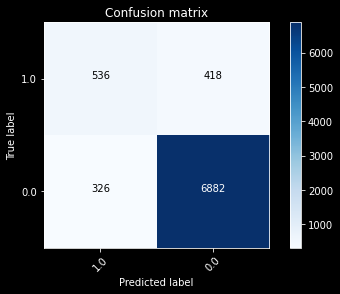

In [82]:
y_true = predictions.select("label")
y_true = y_true.toPandas()

y_pred = predictions.select("prediction")
y_pred = y_pred.toPandas()

cnf_matrix = confusion_matrix(y_true, y_pred,labels=class_names)
#cnf_matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix')
plt.show()

## Accuracy

In [83]:
accuracy = predictions.filter(predictions.label == predictions.prediction).count() / float(predictions.count())
print("Accuracy : ",accuracy)

Accuracy :  0.908845871110022


## ROC Curve

C:\Apps\opt\spark-3.3.0-bin-hadoop3\python\pyspark\sql\context.py:157: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


Logistic Regression With SMOTE Area Under ROC
Area under ROC = 0.931


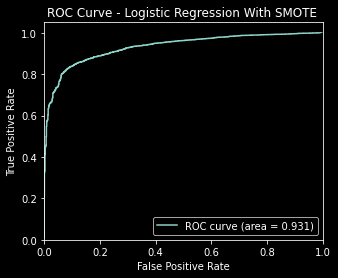

In [84]:
#ROC Grafik
PredAndLabels           = predictions.select("probability", "label")
PredAndLabels_collect   = PredAndLabels.collect()
PredAndLabels_list      = [(float(i[0][0]), 1.0-float(i[1])) for i in PredAndLabels_collect]
PredAndLabels           = sc.parallelize(PredAndLabels_list)

metrics = BinaryClassificationMetrics(PredAndLabels)

# Area under ROC
print("Logistic Regression With SMOTE Area Under ROC")
print("Area under ROC = %.3f" % metrics.areaUnderROC)

# Visualization
FPR = dict()                                                        # FPR: False Positive Rate
tpr = dict()                                                        # TPR: True Positive Rate
roc_auc = dict()
 
y_test = [i[1] for i in PredAndLabels_list]
y_score = [i[0] for i in PredAndLabels_list]
 
fpr, tpr, _ = roc_curve(y_test, y_score)
roc_auc = auc(fpr, tpr)
 
plt.figure(figsize=(5,4))
plt.plot(fpr, tpr, label='ROC curve (area = %0.3f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Logistic Regression With SMOTE ')
plt.legend(loc="lower right")
plt.show()

In [85]:
models_list.append('LogisticRegression_WithSMOTE')
accuracies_list.append(accuracy)
aucs_list.append(metrics.areaUnderROC)
model_objects_list.append(lrModel)

# Model 2:DecisionTreeClassifier

In [86]:
from pyspark.ml.classification import DecisionTreeClassifier

dt = DecisionTreeClassifier(featuresCol = 'features', labelCol = 'label', maxDepth = 3)
dtModel = dt.fit(train)
predictions = dtModel.transform(test)
predictions.select('label', 'features',  'rawPrediction', 'prediction', 'probability').toPandas().head(5)

,label,features,rawPrediction,prediction,probability
0,0.0,"(1.7887710413414055, 0.3041253720315...","[24866.0, 1154.0]",0.0,"[0.9556495003843197, 0.0443504996156..."
1,1.0,"(1.7887710413414055, 0.7445828073876...","[24866.0, 1154.0]",0.0,"[0.9556495003843197, 0.0443504996156..."
2,1.0,"(1.7887710413414055, 1.0452124854878...","[24866.0, 1154.0]",0.0,"[0.9556495003843197, 0.0443504996156..."
3,1.0,"(1.7887710413414055, 1.5311139419520...","[24866.0, 1154.0]",0.0,"[0.9556495003843197, 0.0443504996156..."
4,0.0,"(1.7887710413414055, 4.0585006543524...","[1084.0, 2037.0]",1.0,"[0.3473245754565844, 0.6526754245434..."


# Confusion Matrix

Confusion matrix, without normalization
[[ 661  293]
 [ 504 6704]]


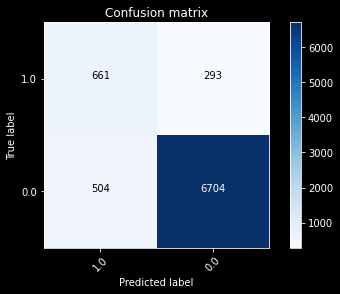

In [87]:
y_true = predictions.select("label")
y_true = y_true.toPandas()

y_pred = predictions.select("prediction")
y_pred = y_pred.toPandas()

cnf_matrix = confusion_matrix(y_true, y_pred,labels=class_names)
#cnf_matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix')
plt.show()

# Accuracy

In [88]:
accuracy = predictions.filter(predictions.label == predictions.prediction).count() / float(predictions.count())
print("Accuracy : ",accuracy)

Accuracy :  0.9023523646165156


# ROC Curve

C:\Apps\opt\spark-3.3.0-bin-hadoop3\python\pyspark\sql\context.py:157: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


Decision Tree Area Under ROC
Area under ROC = 0.867


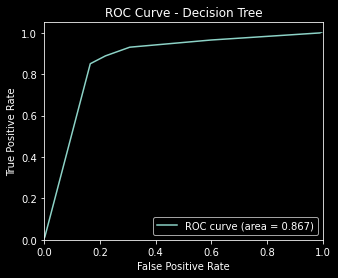

In [89]:
#ROC Grafik
PredAndLabels           = predictions.select("probability", "label")
PredAndLabels_collect   = PredAndLabels.collect()
PredAndLabels_list      = [(float(i[0][0]), 1.0-float(i[1])) for i in PredAndLabels_collect]
PredAndLabels           = sc.parallelize(PredAndLabels_list)

metrics = BinaryClassificationMetrics(PredAndLabels)

# Area under ROC
print("Decision Tree Area Under ROC")
print("Area under ROC = %.3f" % metrics.areaUnderROC)

# Visualization
FPR = dict()                                                        # FPR: False Positive Rate
tpr = dict()                                                        # TPR: True Positive Rate
roc_auc = dict()
 
y_test = [i[1] for i in PredAndLabels_list]
y_score = [i[0] for i in PredAndLabels_list]
 
fpr, tpr, _ = roc_curve(y_test, y_score)
roc_auc = auc(fpr, tpr)
 
plt.figure(figsize=(5,4))
plt.plot(fpr, tpr, label='ROC curve (area = %0.3f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Decision Tree')
plt.legend(loc="lower right")
plt.show()

In [90]:
models_list.append('DecisionTreeClassifier_WithSMOTE')
accuracies_list.append(accuracy)
aucs_list.append(metrics.areaUnderROC)
model_objects_list.append(dtModel)

#  Random Forest Classifier

In [91]:
from pyspark.ml.classification import RandomForestClassifier

rf = RandomForestClassifier(featuresCol = 'features', labelCol = 'label')
rfModel = rf.fit(train)
predictions = rfModel.transform(test)
predictions.select('label', 'features',  'rawPrediction', 'prediction', 'probability').toPandas().head(5)

,label,features,rawPrediction,prediction,probability
0,0.0,"(1.7887710413414055, 0.3041253720315...","[18.853924441236806, 1.146075558763196]",0.0,"[0.9426962220618401, 0.0573037779381..."
1,1.0,"(1.7887710413414055, 0.7445828073876...","[16.33582602602327, 3.6641739739767307]",0.0,"[0.8167913013011635, 0.1832086986988..."
2,1.0,"(1.7887710413414055, 1.0452124854878...","[16.342173166221876, 3.657826833778125]",0.0,"[0.8171086583110938, 0.1828913416889..."
3,1.0,"(1.7887710413414055, 1.5311139419520...","[14.26430869631363, 5.73569130368637]",0.0,"[0.7132154348156815, 0.2867845651843..."
4,0.0,"(1.7887710413414055, 4.0585006543524...","[10.039698018982802, 9.960301981017194]",0.0,"[0.5019849009491402, 0.4980150990508..."


Confusion matrix, without normalization
[[ 421  533]
 [ 245 6963]]


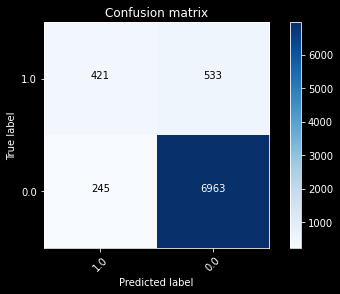

In [92]:
y_true = predictions.select("label")
y_true = y_true.toPandas()

y_pred = predictions.select("prediction")
y_pred = y_pred.toPandas()

cnf_matrix = confusion_matrix(y_true, y_pred,labels=class_names)
#cnf_matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix')
plt.show()

In [93]:
accuracy = predictions.filter(predictions.label == predictions.prediction).count() / float(predictions.count())
print("Accuracy : ",accuracy)

Accuracy :  0.9046802254349424


## ROC Curve

C:\Apps\opt\spark-3.3.0-bin-hadoop3\python\pyspark\sql\context.py:157: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


Random Forest With SMOTE Area Under ROC
Area under ROC = 0.928


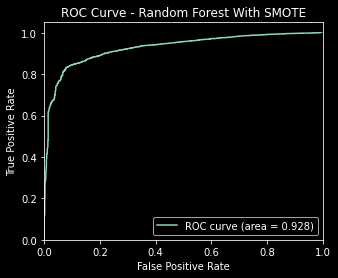

In [94]:
#ROC Grafik
PredAndLabels           = predictions.select("probability", "label")
PredAndLabels_collect   = PredAndLabels.collect()
PredAndLabels_list      = [(float(i[0][0]), 1.0-float(i[1])) for i in PredAndLabels_collect]
PredAndLabels           = sc.parallelize(PredAndLabels_list)

metrics = BinaryClassificationMetrics(PredAndLabels)

# Area under ROC
print("Random Forest With SMOTE Area Under ROC")
print("Area under ROC = %.3f" % metrics.areaUnderROC)

# Visualization
FPR = dict()                                                        # FPR: False Positive Rate
tpr = dict()                                                        # TPR: True Positive Rate
roc_auc = dict()
 
y_test = [i[1] for i in PredAndLabels_list]
y_score = [i[0] for i in PredAndLabels_list]
 
fpr, tpr, _ = roc_curve(y_test, y_score)
roc_auc = auc(fpr, tpr)
 
plt.figure(figsize=(5,4))
plt.plot(fpr, tpr, label='ROC curve (area = %0.3f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Random Forest With SMOTE')
plt.legend(loc="lower right")
plt.show()

In [95]:
models_list.append('RandomForestClassifier_WithSMOTE')
accuracies_list.append(accuracy)
aucs_list.append(metrics.areaUnderROC)
model_objects_list.append(rfModel)

 # Gradient-boosted Tree Classifier

In [96]:
from pyspark.ml.classification import GBTClassifier

gbt = GBTClassifier(maxIter=10)
gbtModel = gbt.fit(train)
predictions = gbtModel.transform(test)
predictions.select('label', 'features',  'rawPrediction', 'prediction', 'probability').toPandas().head(5)

,label,features,rawPrediction,prediction,probability
0,0.0,"(1.7887710413414055, 0.3041253720315...","[1.305998927400568, -1.305998927400568]",0.0,"[0.9316297609230454, 0.0683702390769..."
1,1.0,"(1.7887710413414055, 0.7445828073876...","[0.6863966792769063, -0.686396679276...",0.0,"[0.7978310877877716, 0.2021689122122..."
2,1.0,"(1.7887710413414055, 1.0452124854878...","[0.6671799813141568, -0.667179981314...",0.0,"[0.7915609092387993, 0.2084390907612..."
3,1.0,"(1.7887710413414055, 1.5311139419520...","[0.6581177455153774, -0.658117745515...",0.0,"[0.788554708503975, 0.21144529149602..."
4,0.0,"(1.7887710413414055, 4.0585006543524...","[-0.3752597950713274, 0.375259795071...",1.0,"[0.32070809527563987, 0.679291904724..."


Confusion matrix, without normalization
[[ 658  296]
 [ 458 6750]]


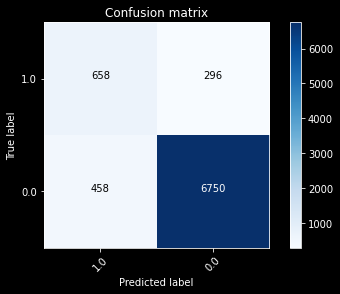

In [97]:
y_true = predictions.select("label")
y_true = y_true.toPandas()

y_pred = predictions.select("prediction")
y_pred = y_pred.toPandas()

cnf_matrix = confusion_matrix(y_true, y_pred,labels=class_names)
#cnf_matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix')
plt.show()

In [98]:
accuracy = predictions.filter(predictions.label == predictions.prediction).count() / float(predictions.count())
print("Accuracy : ",accuracy)

Accuracy :  0.9076206812055869


## ROC Curve

C:\Apps\opt\spark-3.3.0-bin-hadoop3\python\pyspark\sql\context.py:157: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


Gradient-boosted Tree With SMOTE Area Under ROC
Area under ROC = 0.941


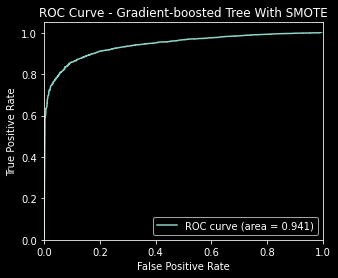

In [99]:
#ROC Grafik
PredAndLabels           = predictions.select("probability", "label")
PredAndLabels_collect   = PredAndLabels.collect()
PredAndLabels_list      = [(float(i[0][0]), 1.0-float(i[1])) for i in PredAndLabels_collect]
PredAndLabels           = sc.parallelize(PredAndLabels_list)

metrics = BinaryClassificationMetrics(PredAndLabels)

# Area under ROC
print("Gradient-boosted Tree With SMOTE Area Under ROC")
print("Area under ROC = %.3f" % metrics.areaUnderROC)

# Visualization
FPR = dict()                                                        # FPR: False Positive Rate
tpr = dict()                                                        # TPR: True Positive Rate
roc_auc = dict()
 
y_test = [i[1] for i in PredAndLabels_list]
y_score = [i[0] for i in PredAndLabels_list]
 
fpr, tpr, _ = roc_curve(y_test, y_score)
roc_auc = auc(fpr, tpr)
 
plt.figure(figsize=(5,4))
plt.plot(fpr, tpr, label='ROC curve (area = %0.3f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Gradient-boosted Tree With SMOTE')
plt.legend(loc="lower right")
plt.show()

In [100]:
models_list.append('GBTClassifier_WithSMOTE')
accuracies_list.append(accuracy)
aucs_list.append(metrics.areaUnderROC)
model_objects_list.append(gbtModel)

In [101]:
results={'model':models_list,'accuracy':accuracies_list,'auc':aucs_list}

In [102]:
pd.DataFrame.from_dict(results)

,model,accuracy,auc
0,LogisticRegression,0.910194,0.934764
1,DecisionTreeClassifier,0.907498,0.854495
2,RandomForestClassifier,0.896962,0.924878
3,GBTClassifier,0.913379,0.943890
4,LogisticRegression_WithSMOTE,0.908846,0.931408
5,DecisionTreeClassifier_WithSMOTE,0.902352,0.867366
6,RandomForestClassifier_WithSMOTE,0.904680,0.927678
7,GBTClassifier_WithSMOTE,0.907621,0.941070


In [208]:
for model, model_name in zip(model_objects_list,models_list):
    if model_name == 'LogisticRegression':
        best_model=model
        break;

In [209]:
best_model.write().overwrite().save('best_model')


In [210]:
best_model

LogisticRegressionModel: uid=LogisticRegression_8b83447dc491, numClasses=2, numFeatures=58

In [219]:
weights = best_model.coefficients
weights = [(float(w),) for w in weights]
pd.DataFrame(weights,columns=['Feature Weight'])

,Feature Weight
0,-0.000753
1,1.160904
2,-0.082914
3,0.180196
4,-0.253373
5,0.190371
6,0.156302
7,-0.261114
8,-0.448385
9,0.037114


# Best Model Parameters

In [220]:
best_model.explainParams().split("\n")

['aggregationDepth: suggested depth for treeAggregate (>= 2). (default: 2)',
 'elasticNetParam: the ElasticNet mixing parameter, in range [0, 1]. For alpha = 0, the penalty is an L2 penalty. For alpha = 1, it is an L1 penalty. (default: 0.0)',
 'family: The name of family which is a description of the label distribution to be used in the model. Supported options: auto, binomial, multinomial (default: auto)',
 'featuresCol: features column name. (default: features, current: features)',
 'fitIntercept: whether to fit an intercept term. (default: True)',
 'labelCol: label column name. (default: label, current: label)',
 'lowerBoundsOnCoefficients: The lower bounds on coefficients if fitting under bound constrained optimization. The bound matrix must be compatible with the shape (1, number of features) for binomial regression, or (number of classes, number of features) for multinomial regression. (undefined)',
 'lowerBoundsOnIntercepts: The lower bounds on intercepts if fitting under bound